# Assignment 2

In [1]:
# Spotify parsing
import billboard
from spotipy.oauth2 import SpotifyClientCredentials
# Pandas work
from collections import defaultdict
from sklearn import linear_model, svm, model_selection, metrics, naive_bayes, neighbors, ensemble
import scipy
import random
import csv
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as sk
import pandas as pd

In [2]:
# https://stackoverflow.com/questions/45927801/trouble-setting-up-credentials-in-spotipy
# https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks <- dataset
import configparser

import spotipy
import spotipy.oauth2 as oauth2

config = configparser.ConfigParser()
config.read('config.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')


auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
spotify = spotipy.Spotify(auth=token)

<ipython-input-2-bf9dc4d44692>:19: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token = auth.get_access_token()


## Data Parsing and Splitting

In [3]:
song_cols = []
song_data = []

with open('combined_spotify_data.csv', encoding='utf-8') as file:
    read_data = csv.reader(file)
    for row in read_data:
        if row[0] == '':
            song_cols = row[1:-1]
        elif int(row[4]) < 1940:
            continue
        else:
            row_data = {}
            
            curr_col = 1
            for col in song_cols:
                row_data[col] = row[curr_col]
                curr_col += 1
            
            song_data.append(row_data)

In [4]:
data_shuffled = song_data.copy()
random.shuffle(data_shuffled)

In [5]:
training = data_shuffled[:116980]
validation = data_shuffled[116980:]

In [6]:
artist_cols = []
artist_data = []

with open('data_w_genres.csv', encoding='utf-8') as file:
    read_data = csv.reader(file) 
    col_labels = False
    for row in read_data:
        if not col_labels: 
            cols = row
            col_labels = !col_labels
        else:
            row_data = {}
            
            curr_col = 0
            for col in cols:
                row_data[col] = row[curr_col]
                curr_col += 1
            
            row_data['num_billboard'] = 0
            
            artist_data.append(row_data)

In [7]:
for i in range(len(artist_data)):
    artist_data[i]['genres'] = artist_data[i]['genres'].strip('][').split(', ')
    for j, thing in enumerate(artist_data[i]['genres']):
        thing = thing.strip('\'')
        artist_data[i]['genres'][j] = thing

In [8]:
genre_counts = defaultdict(int)

for artist in artist_data:
    for genre in artist['genres']:
        if genre != '':
            genre_counts[genre] += 1

returned_genres_median = [d for d in genre_counts if genre_counts[d] > 4]
returned_genres_mean = [d for d in genre_counts if genre_counts[d] >= 22]
genre_ids_median = dict(zip(list(returned_genres_median),range(len(returned_genres_median))))
genre_ids_mean = dict(zip(list(returned_genres_mean),range(len(returned_genres_mean))))

In [10]:
for i in range(len(song_data)):
    song_data[i]['artists'] = song_data[i]['artists'].strip('][').split(', ')
    for j, thing in enumerate(song_data[i]['artists']):
        thing = thing.strip('\'')
        song_data[i]['artists'][j] = thing

In [11]:
billboard_songs = [d for d in song_data if d['on_billboard'] == '1']

In [12]:
for song in billboard_songs:
    for artist in song['artists']:
        for a in artist_data:
            if a['artists'] == artist:
                a['num_billboard'] += 1
                break

In [13]:
billboard_artists = [d for d in artist_data if d['num_billboard'] > 0]

## Baseline Creation

In [14]:
# First Baseline: Popularity Threshold (Median)
popularities = [int(d['popularity']) for d in training]

cut_off = np.median(popularities)

In [15]:
actual_on_billboard = [bool(int(d['on_billboard'])) for d in validation]
pred_on_billboard = []

for d in validation:
    pred_on_billboard.append(int(d['popularity']) > cut_off)
    

In [16]:
# Method to calculate the BER given predictions and y values
def calcBER(predictions, y):
    # True positives, false positives, etc.
    TP_ = np.logical_and(predictions, y)
    FP_ = np.logical_and(predictions, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(predictions), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(predictions), y)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)

    # BER
    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

    print('BER: {}'.format(BER))
    
    # Accuracy
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    
    print('Accuracy: {}'.format(accuracy))

In [17]:
calcBER(pred_on_billboard, actual_on_billboard)

BER: 0.3039766154656911
Accuracy: 0.57028565567465


In [18]:
# Second Baseline: 'Pop' Music Traits Threshold (Median)
energy_indices = [float(d['energy']) for d in training]
tempos = [float(d['tempo']) for d in training]
danceability_indices = [float(d['danceability']) for d in training]
valence_indices = [float(d['valence']) for d in training]

energy_cut_off = np.median(energy_indices)
tempo_cut_off = np.median(tempos)
dance_cut_off = np.median(danceability_indices)
valence_cut_off = np.median(valence_indices)

In [19]:
tempo_cut_off

115.03150000000001

In [20]:
actual_on_billboard_two = [bool(int(d['on_billboard'])) for d in validation]
pred_on_billboard_two = []

for d in validation:
    pred_on_billboard_two.append(float(d['energy']) > energy_cut_off and 
                                 float(d['tempo']) > tempo_cut_off and
                                 float(d['danceability']) > dance_cut_off and
                                 float(d['valence']) > valence_cut_off)

In [21]:
calcBER(pred_on_billboard_two, actual_on_billboard)

BER: 0.44915938489047225
Accuracy: 0.8254013026309042


## Model Building

### Utility Functions

In [22]:
def model_run_one(train_X, train_y, valid_X, valid_y):
    # --------------- Run Naive Bayes ---------------
    mod = naive_bayes.MultinomialNB()
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run Naive Bayes ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    
    # --------------- Run Logistic Regression ---------------
    mod = linear_model.LogisticRegression(C=0.01, class_weight='balanced')
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run Logistic Regression ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    # --------------- Run SVM ---------------
    mod = svm.LinearSVC(class_weight='balanced', random_state=0, max_iter=50000)
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run SVM ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    # --------------- Run Random Forest ---------------
    mod = ensemble.RandomForestClassifier()
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run Random Forest ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    
    # --------------- Run KNeighbors ---------------
    mod = neighbors.KNeighborsClassifier()
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run KNeighbors ---------------')
    calcBER(pred_y, valid_y)
    print()

In [23]:
def model_run_two(train_X, train_y, valid_X, valid_y):
    # --------------- Run Naive Bayes ---------------
    mod = naive_bayes.MultinomialNB()
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run Naive Bayes ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    
    # --------------- Run Logistic Regression ---------------
    mod = linear_model.LogisticRegression(C=0.01, class_weight='balanced')
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run Logistic Regression ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    # --------------- Run SVM ---------------
    mod = svm.LinearSVC(class_weight='balanced', random_state=0, max_iter=50000)
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run SVM ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    # --------------- Run Random Forest ---------------
    mod = ensemble.RandomForestClassifier()
    mod.fit(train_X, train_y)
    pred_y = mod.predict(valid_X)
    print('--------------- Run Random Forest ---------------')
    calcBER(pred_y, valid_y)
    print()
    
    

### First Model: Threshold Feature Vector

In [24]:
#-------------------First Model: Threshold Feature Vector-------------------
def feature_thresh(datum):
    feat = [0]
    feat.append(int(float(datum['energy']) > energy_cut_off))
    feat.append(int(float(d['tempo']) > tempo_cut_off))
    feat.append(int(float(d['danceability']) > dance_cut_off))
    feat.append(int(float(d['valence']) > valence_cut_off))
    return feat

In [25]:
X_first = [feature_thresh(d) for d in training]
y_first = [bool(int(d['on_billboard'])) for d in training]

X_first_valid = [feature_thresh(d) for d in validation]
y_first_valid = [bool(int(d['on_billboard'])) for d in validation]

In [26]:
model_run_one(X_first, y_first, X_first_valid, y_first_valid)

--------------- Run Naive Bayes ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run Logistic Regression ---------------
BER: 0.37043394552652387
Accuracy: 0.5420534386378789

--------------- Run SVM ---------------
BER: 0.37043394552652387
Accuracy: 0.5420534386378789

--------------- Run Random Forest ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run KNeighbors ---------------
BER: 0.37043394552652387
Accuracy: 0.5420534386378789



### Second Model: Pure Feature Vector

In [27]:
#-------------------Second Model: Pure Feature Vector-------------------
def feature_puer(datum):
    feat = [0]
    feat.append(float(datum['energy']))
    feat.append(float(d['tempo']))
    feat.append(float(d['danceability']))
    feat.append(float(d['valence']))
    return feat

In [28]:
X_second = [feature_puer(d) for d in training]
y_second = [bool(int(d['on_billboard'])) for d in training]

X_second_valid = [feature_puer(d) for d in validation]
y_second_valid = [bool(int(d['on_billboard'])) for d in validation]

In [29]:
model_run_one(X_second, y_second, X_second_valid, y_second_valid)

--------------- Run Naive Bayes ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run Logistic Regression ---------------
BER: 0.3798243838549975
Accuracy: 0.5977742448330684



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.5
Accuracy: 0.09272270372839633

--------------- Run Random Forest ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run KNeighbors ---------------
BER: 0.4945664931120919
Accuracy: 0.8977639878968152



### Third Model: Popularity and 'Pop' Music Traits Puer Vector

In [30]:
#-----Third Model: Popularity and 'Pop' Music Traits Puer Vector----
def feature_pop_thresh(datum):
    feat = [0]
    feat.append(int(d['popularity']))
    feat.append(float(datum['energy']))
    feat.append(float(d['tempo']))
    feat.append(float(d['danceability']))
    feat.append(float(d['valence']))
    return feat

In [31]:
X_third = [feature_pop_thresh(d) for d in training]
y_third = [bool(int(d['on_billboard'])) for d in training]

X_third_valid = [feature_pop_thresh(d) for d in validation]
y_third_valid = [bool(int(d['on_billboard'])) for d in validation]

In [32]:
model_run_one(X_third, y_third, X_third_valid, y_third_valid)

--------------- Run Naive Bayes ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run Logistic Regression ---------------
BER: 0.3798243838549975
Accuracy: 0.5977742448330684



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.5
Accuracy: 0.09272270372839633

--------------- Run Random Forest ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run KNeighbors ---------------
BER: 0.4945664931120919
Accuracy: 0.8977639878968152



## Model Refinement

In [33]:
artist_ids = defaultdict(int)

curr_id = 0
for artist in artist_data:
    artist_ids[artist['artists']] = curr_id
    curr_id += 1

### Model Refinement #1: Number of Billboard Hits Variable

In [34]:
# Model Refinement #1: Number of Billboard Hits Variable
def feature_superstar(datum):
    feat = [0]
    superstar = 0
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        superstar += artist_data[artist_id]['num_billboard']
    feat.append(superstar)
    return feat

In [35]:
X_ref_first = [feature_superstar(d) for d in training]
y_ref_first = [bool(int(d['on_billboard'])) for d in training]

X_ref_first_valid = [feature_superstar(d) for d in validation]
y_ref_first_valid = [bool(int(d['on_billboard'])) for d in validation]

In [36]:
model_run_one(X_ref_first, y_ref_first, X_ref_first_valid, y_ref_first_valid)

--------------- Run Naive Bayes ---------------
BER: 0.5
Accuracy: 0.9072772962716037

--------------- Run Logistic Regression ---------------
BER: 0.3356938062351589
Accuracy: 0.7886814708446587



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.3458497517986997
Accuracy: 0.7988614800759013

--------------- Run Random Forest ---------------
BER: 0.48842144123080433
Accuracy: 0.9066618800964152

--------------- Run KNeighbors ---------------
BER: 0.4603894401207954
Accuracy: 0.8870198471716498



### Model Refinement #2: Number of Billboard Hits Variable with Instrumentalness, Danceability, Song Popularity, and Artist Popularity

In [37]:
# Model Refinement #2: Number of Billboard Hits Variable with Acousticness, Valence, Song Popularity, and Artist Popularity
def feature_superstar_two(datum):
    feat = [0]
    superstar = 0
    tot_artist_pop = 0
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        superstar += artist_data[artist_id]['num_billboard']
        tot_artist_pop += float(artist_data[artist_id]['popularity'])
    feat.append(superstar)
    feat.append(float(datum['instrumentalness']))
    feat.append(float(datum['danceability']))
    feat.append(float(datum['popularity']))
    feat.append(tot_artist_pop)
    return feat

In [38]:
X_ref_second = [feature_superstar_two(d) for d in training]
y_ref_second = [bool(int(d['on_billboard'])) for d in training]

X_ref_second_valid = [feature_superstar_two(d) for d in validation]
y_ref_second_valid = [bool(int(d['on_billboard'])) for d in validation]

In [39]:
model_run_one(X_ref_second, y_ref_second, X_ref_second_valid, y_ref_second_valid)

--------------- Run Naive Bayes ---------------
BER: 0.3714799172920784
Accuracy: 0.8134006872147289

--------------- Run Logistic Regression ---------------
BER: 0.2561848357471901
Accuracy: 0.7333709420995949



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.26977463698355697
Accuracy: 0.7760654392532951

--------------- Run Random Forest ---------------
BER: 0.37187403549527454
Accuracy: 0.9154059182522181

--------------- Run KNeighbors ---------------
BER: 0.35021181430435855
Accuracy: 0.9116877788604544



### Model Refinement #3: Number of Billboard Hits Variable, Acousticness, Valence, Song Popularity, and Artist Popularity

In [40]:
# Model Refinement #3: Number of Billboard Hits Variable, Acousticness, Valence, Song Popularity, and Artist Popularity
def feature_superstar_three(datum):
    feat = [0]
    tot_artist_pop = 0
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        tot_artist_pop += float(artist_data[artist_id]['popularity'])
    feat.append(float(datum['instrumentalness']))
    feat.append(float(datum['danceability']))
    feat.append(float(datum['popularity']))
    feat.append(tot_artist_pop)
    return feat

In [41]:
X_ref_third = [feature_superstar_three(d) for d in training]
y_ref_third = [bool(int(d['on_billboard'])) for d in training]

X_ref_third_valid = [feature_superstar_three(d) for d in validation]
y_ref_third_valid = [bool(int(d['on_billboard'])) for d in validation]

In [42]:
model_run_one(X_ref_third, y_ref_third, X_ref_third_valid, y_ref_third_valid)

--------------- Run Naive Bayes ---------------
BER: 0.4229600443678426
Accuracy: 0.9022257551669316

--------------- Run Logistic Regression ---------------
BER: 0.2768445035173628
Accuracy: 0.6875480793886866



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.2794791333701503
Accuracy: 0.6435714652033437

--------------- Run Random Forest ---------------
BER: 0.43606946910158306
Accuracy: 0.907046515205908

--------------- Run KNeighbors ---------------
BER: 0.42418644260893623
Accuracy: 0.9002256525975691



## Model Refinement The Sequel: Genre Trials

### Purely Artist Genre From Median

In [43]:
def feat_genres_median(datum):
    feat = [0] * len(returned_genres_median)
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        for genre in artist_data[artist_id]['genres']:
            if genre in returned_genres_median:
                feat[genre_ids_median[genre]] = 1
    feat.insert(0, 0)
    return feat

In [44]:
X_ref_seq_one = [feat_genres_median(d) for d in training]
y_ref_seq_one = [bool(int(d['on_billboard'])) for d in training]

X_ref_seq_one_valid = [feat_genres_median(d) for d in validation]
y_ref_seq_one_valid = [bool(int(d['on_billboard'])) for d in validation]

In [45]:
model_run_two(X_ref_seq_one, y_ref_seq_one, X_ref_seq_one_valid, y_ref_seq_one_valid)

--------------- Run Naive Bayes ---------------
BER: 0.2793149565325701
Accuracy: 0.8225037181393917

--------------- Run Logistic Regression ---------------
BER: 0.24198663837369438
Accuracy: 0.7609364582799117

--------------- Run SVM ---------------
BER: 0.23376255513152777
Accuracy: 0.7308067080363095

--------------- Run Random Forest ---------------
BER: 0.4289026284176295
Accuracy: 0.9045079234832556



### Purely Artist Genre from Mean

In [46]:
def feat_genres_mean(datum):
    feat = [0] * len(returned_genres_mean)
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        for genre in artist_data[artist_id]['genres']:
            if genre in returned_genres_mean:
                feat[genre_ids_mean[genre]] = 1
    feat.insert(0, 0)
    return feat

In [47]:
X_ref_seq_two = [feat_genres_mean(d) for d in training]
y_ref_seq_two = [bool(int(d['on_billboard'])) for d in training]

X_ref_seq_two_valid = [feat_genres_mean(d) for d in validation]
y_ref_seq_two_valid = [bool(int(d['on_billboard'])) for d in validation]

In [48]:
model_run_two(X_ref_seq_two, y_ref_seq_two, X_ref_seq_two_valid, y_ref_seq_two_valid)

--------------- Run Naive Bayes ---------------
BER: 0.28877863156507266
Accuracy: 0.8307861941638033

--------------- Run Logistic Regression ---------------
BER: 0.24394680273405356
Accuracy: 0.7587312169854864

--------------- Run SVM ---------------
BER: 0.23423874221330476
Accuracy: 0.7344479204061747

--------------- Run Random Forest ---------------
BER: 0.42901460944843206
Accuracy: 0.9054310477460382



### Genre Superstar

In [49]:
def feat_genre_soup(datum):
    feat = [0] * len(returned_genres_mean)
    superstar = 0
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        superstar += artist_data[artist_id]['num_billboard']
        for genre in artist_data[artist_id]['genres']:
            if genre in returned_genres_mean:
                feat[genre_ids_mean[genre]] = 1
    
    feat.append(superstar)
    feat.insert(0, 0)
    return feat

In [50]:
X_ref_seq_three = [feat_genre_soup(d) for d in training]
y_ref_seq_three = [bool(int(d['on_billboard'])) for d in training]

X_ref_seq_three_valid = [feat_genre_soup(d) for d in validation]
y_ref_seq_three_valid = [bool(int(d['on_billboard'])) for d in validation]

In [51]:
model_run_two(X_ref_seq_three, y_ref_seq_three, X_ref_seq_three_valid, y_ref_seq_three_valid)

--------------- Run Naive Bayes ---------------
BER: 0.3007385292406568
Accuracy: 0.8160674906405456



D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------- Run Logistic Regression ---------------
BER: 0.2378217912913071
Accuracy: 0.7702959126109031



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.23181279397853916
Accuracy: 0.7458331196471614

--------------- Run Random Forest ---------------
BER: 0.4099561758441246
Accuracy: 0.9050976973178112



### Genre, Precedence, et. al.

In [52]:
def feat_genre_soup_plus(datum):
    feat = [0] * len(returned_genres_mean)
    superstar = 0
    tot_artist_pop = 0
    for artist in datum['artists']:
        artist_id = artist_ids[artist]
        superstar += artist_data[artist_id]['num_billboard']
        tot_artist_pop += float(artist_data[artist_id]['popularity'])
        for genre in artist_data[artist_id]['genres']:
            if genre in returned_genres_mean:
                feat[genre_ids_mean[genre]] = 1
    
    feat.append(superstar)
    feat.append(tot_artist_pop)
    feat.append(float(datum['instrumentalness']))
    feat.append(float(datum['danceability']))
    feat.append(float(datum['popularity']))
    feat.insert(0, 0)
    return feat

In [53]:
X_ref_seq_four = [feat_genre_soup_plus(d) for d in training]
y_ref_seq_four = [bool(int(d['on_billboard'])) for d in training]

X_ref_seq_four_valid = [feat_genre_soup_plus(d) for d in validation]
y_ref_seq_four_valid = [bool(int(d['on_billboard'])) for d in validation]

In [54]:
model_run_two(X_ref_seq_four, y_ref_seq_four, X_ref_seq_four_valid, y_ref_seq_four_valid)

--------------- Run Naive Bayes ---------------
BER: 0.317883991997831
Accuracy: 0.8045540796963947



D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------- Run Logistic Regression ---------------
BER: 0.1869492083995512
Accuracy: 0.7934509462023693



D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------- Run SVM ---------------
BER: 0.19007037382890046
Accuracy: 0.8224780757987589

--------------- Run Random Forest ---------------
BER: 0.35008338823350504
Accuracy: 0.9162008308118365



## Final Model

In [65]:
genre

610

In [ ]:
# Cross-Reference with Artist Data Possibly
# Any Derived Features?????????? -> Genre for Categorization
# Incorporate the Temporal Elements??????

## Random Shit from the Past

In [11]:
import spotipy
import sys
from spotipy.oauth2 import SpotifyClientCredentials

In [100]:
# client_credentials_manager = SpotifyClientCredentials()
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
spotify.trace = False

In [41]:
findURI = spotify.search(q='artist:' + data[0]['artist'], limit=50)

In [13]:
findURI = spotify.search(q='year:1955', limit=50)

In [56]:
uri = findURI['tracks']['items'][0]['uri']
# for i, t in enumerate(findURI['tracks']['items']):
#     print(i)
#     print(t)

In [9]:
# load Billboard dataset
df = pd.read_csv('billboard_hot_100_all.tsv', sep='\t', encoding = "ISO-8859-1")

In [11]:
df.tail(10)

,Date,Song,Artist,Peak Position,Last Position,Weeks on Chart,Rank,isNew
325277,1958-08-11,All I Have To Do Is Dream,The Everly Brothers,49,49,2,91,False
325278,1958-08-11,La Paloma,Billy Vaughn And His Orchestra,92,0,1,92,True
325279,1958-08-11,I Believe In You,Robert & Johnny,93,97,2,93,False
325280,1958-08-11,Midnighter,The Champs,94,0,1,94,True
325281,1958-08-11,Chariot Rock,The Champs,95,0,1,95,True
325282,1958-08-11,Down In Virginia,Jimmy Reed,96,0,1,96,True
325283,1958-08-11,Sunday Barbecue,Tennessee Ernie Ford,97,0,1,97,True
325284,1958-08-11,Gotta Have Rain,Eydie Gorme,74,74,2,98,False
325285,1958-08-11,Nothing In The World,Nat King Cole,99,0,1,99,True
325286,1958-08-11,"Baubles, Bangles And Beads",The Kirby Stone Four,50,50,2,100,False


In [54]:
df.iloc[0].Date[-4:]

'2020'

In [55]:
# Remove all rows containing date of "2020"
cleaned_df = df[~df.Date.str.contains('2020', na=False)] 

In [56]:
cleaned_df.head(10)

,Date,Song,Artist,Peak Position,Last Position,Weeks on Chart,Rank,isNew
4900,12/28/2019,All I Want For Christmas Is You,Mariah Carey,1,1,36,1,False
4901,12/28/2019,Rockin' Around The Christmas Tree,Brenda Lee,2,3,31,2,False
4902,12/28/2019,Circles,Post Malone,1,2,16,3,False
4903,12/28/2019,Roxanne,Arizona Zervas,4,6,7,4,False
4904,12/28/2019,Futsal Shuffle 2020,Lil Uzi Vert,5,0,1,5,True
4905,12/28/2019,A Holly Jolly Christmas,Burl Ives,6,10,14,6,False
4906,12/28/2019,Memories,Maroon 5,4,7,13,7,False
4907,12/28/2019,Someone You Loved,Lewis Capaldi,1,4,32,8,False
4908,12/28/2019,Jingle Bell Rock,Bobby Helms,8,15,29,9,False
4909,12/28/2019,Good As Hell,Lizzo,3,5,17,10,False


In [142]:
# Dictionary with key=[YEAR] which maps to a set of all distinct songs of that year
year_song_dict = defaultdict(set)

In [143]:
# Get each row of df 
for _, row in cleaned_df.iterrows():
    year = row['Date'][-4:]
    song = row['Song']
    artist = row['Artist']
    # Delete everything after "featuring"
    idx = -1
    idx = row['Artist'].find(" Feat")
    if idx == -1:
        idx = row['Artist'].find(" feat")
    if idx != -1:
        artist = artist[:idx]
    
    # Remove all the "&"
    artist = artist.replace(" & ", " ")
    artist = artist.replace(" and ", " ")
    artist = artist.replace(" And ", " ")
    artist = artist.replace(" with ", " ")
    artist = artist.replace(" With ", " ")
    artist = artist.replace(" X ", " ")
    artist = artist.replace(" x ", " ")
    
#     print(row['Song'])
    year_song_dict[year].add((song, artist))

In [12]:
# Get spotify dataset
s_df = pd.read_csv('data.csv')

In [18]:
# Reorder columns in dataframes
s_df = s_df[['id', 'name', 'artists', 'year', 'release_date', 'duration_ms', 'valence', 'acousticness', 'danceability', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']]
# Create new column to hold boolean of whether it has been on Billboard or not
s_df['on_billboard'] = 0

In [19]:
s_df.sort_values(by=['year'])
s_df = s_df[s_df['year'] >= 1940]

In [27]:
s_df = s_df.reset_index()
s_df = s_df.drop(columns = ["index"])

,level_0,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,...,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard
0,0,6kucJsz2GR6oN8glzqGdTh,Main Title - Gone With the Wind,['Max Steiner'],1940,1940-01-17,246773,0.171,0.680,0.170,...,0,0.854000,5,0.459,-8.326,1,33,0.0357,121.800,0
1,1,3LKwoKXJBpWBSKID58IgYw,Let's Do It (with Eddie Heywood & His Orchestr...,"['Billie Holiday', 'Eddie Heywood']",1940,1940,175893,0.597,0.983,0.543,...,0,0.000171,5,0.258,-14.450,0,23,0.0537,142.312,0
2,2,1GoA6bkY0rZsc7aAHGlfl5,9:20 Special,['Count Basie'],1940,1940,187400,0.876,0.871,0.513,...,0,0.089200,2,0.297,-14.557,0,27,0.1010,198.665,0
3,3,5SikmTT1Bf2M1NetWLeDyi,Seven Come Eleven (feat. Benny Goodman & Charl...,"['Benny Goodman Sextet', 'Benny Goodman', 'Cha...",1940,1940,165800,0.823,0.727,0.703,...,0,0.016000,1,0.185,-6.975,1,26,0.0292,115.688,0
4,4,5HjcDXSfMbBmG4x04wELjK,"Final Speech (From ""The Great Dictator"")",['Charlie Chaplin'],1940,1940,222867,0.629,0.885,0.721,...,0,0.000000,2,0.503,-8.429,1,25,0.6590,124.404,0


In [294]:
# Iterate through set
for r in range(1963, 1957, -1):
    
    print("Setting for year: {}".format(r))
    
    for song, artist in year_song_dict[str(r)]:
#         print(song, artist)
        # Search on spotify for song
        search_str = "{} {}".format(song, artist)
        findURI = spotify.search(q=search_str, limit=1)

        # If we don't have any songs pop up, song is not on Spotify
        if len(findURI['tracks']) == 0 or len(findURI['tracks']['items']) == 0:
            continue
            
        # Get id of the song
        uri = findURI['tracks']['items'][0]['uri']
        features = spotify.audio_features(uri)
        s_id = features[0]['id']
        
        # Find the row where == song id
        row = s_df.loc[s_df['id'] == s_id]
        
        # Song isn't in dataset, skip
        if len(row) == 0:
            continue
            
        s_df.loc[s_df['id'] == s_id, ['on_billboard']] = 1 
#         row = s_df.loc[s_df['id'] == s_id]
#         print(row['year_on_billboard'].tolist())
#         print(row['on_billboard'])
#         print(row['year_on_billboard'])
        list(row['year_on_billboard']).append(r)

Setting for year: 1963
Setting for year: 1962
Setting for year: 1961
Setting for year: 1960
Setting for year: 1959
Setting for year: 1958


In [296]:
s_df.to_csv('combined_spotify_data.csv')

In [283]:
findURI = spotify.search(q="You Saved My Soul Burton Cummings", limit=1)

In [285]:
uri = findURI['tracks']['items'][0]['uri']

In [287]:
features = spotify.audio_features(uri)

In [169]:
s_df.loc[s_df['id'] == '5MPPttjfGap2C6j6eKcO6J', ['on_billboard']] = 1 

In [248]:
row = s_df.loc[s_df['id'] == '2QEnZJ8FwpBoyLKcFcgceT']

In [251]:
row

,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,energy,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard


In [194]:
list(row['year_on_billboard'])[0].append("2019")

In [252]:
len(row)

0

In [2]:
df = pd.read_csv('combined_spotify_data.csv', encoding = "ISO-8859-1")

In [3]:
df = df.iloc[26170:]

In [6]:
df = df.reset_index()

,index,Unnamed: 0,id,name,artists,year,release_date,duration_ms,valence,acousticness,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard
0,26170,26170,43qTHtzIXt8ehFgcncwglq,Locomotion - Rudy Van Gelder Edition/2003 Digi...,['John Coltrane'],1958,1958,434240,0.851,0.765,...,0.017700,3,0.320,-6.864,1,36,0.0520,133.913,0,[]
1,26171,26171,2XVos0r3E8DwB4bFUTO0B5,Shipoopi,"['Iggie Wolfington', 'The Original Broadway Ca...",1958,1958-01-01,131627,0.965,0.339,...,0.000000,0,0.299,-11.078,0,32,0.1980,140.702,0,[]
2,26172,26172,139zPoDyCUktM8HH6qeYXE,Any Way You Want Me (That's How I Will Be),['Elvis Presley'],1958,1958-03-21,133840,0.450,0.914,...,0.004060,0,0.120,-11.498,1,38,0.0304,103.609,0,[]
3,26173,26173,5wA0InjAoSZedEhGjjm9hR,Big River,['Johnny Cash'],1958,1958-11-13,151339,0.868,0.828,...,0.000015,5,0.122,-8.972,1,34,0.0882,183.758,0,[]
4,26174,26174,4tPrPQPTlbLCnlzJqRTqsS,Caribe Soy,"['Leo Marini', 'La Sonora Matancera']",1958,1958-01-01,166707,0.558,0.831,...,0.000020,5,0.132,-9.385,1,43,0.0312,118.777,0,[]


In [13]:
df = df.drop(columns = ["index", "Unnamed: 0"])
df.head()

,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,energy,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard
0,43qTHtzIXt8ehFgcncwglq,Locomotion - Rudy Van Gelder Edition/2003 Digi...,['John Coltrane'],1958,1958,434240,0.851,0.765,0.514,0.701,...,0.017700,3,0.320,-6.864,1,36,0.0520,133.913,0,[]
1,2XVos0r3E8DwB4bFUTO0B5,Shipoopi,"['Iggie Wolfington', 'The Original Broadway Ca...",1958,1958-01-01,131627,0.965,0.339,0.634,0.495,...,0.000000,0,0.299,-11.078,0,32,0.1980,140.702,0,[]
2,139zPoDyCUktM8HH6qeYXE,Any Way You Want Me (That's How I Will Be),['Elvis Presley'],1958,1958-03-21,133840,0.450,0.914,0.358,0.324,...,0.004060,0,0.120,-11.498,1,38,0.0304,103.609,0,[]
3,5wA0InjAoSZedEhGjjm9hR,Big River,['Johnny Cash'],1958,1958-11-13,151339,0.868,0.828,0.644,0.623,...,0.000015,5,0.122,-8.972,1,34,0.0882,183.758,0,[]
4,4tPrPQPTlbLCnlzJqRTqsS,Caribe Soy,"['Leo Marini', 'La Sonora Matancera']",1958,1958-01-01,166707,0.558,0.831,0.640,0.366,...,0.000020,5,0.132,-9.385,1,43,0.0312,118.777,0,[]


In [18]:
plt.show()

In [59]:
bb_df = df[df["on_billboard"] == 1]
nbb_df = df[df["on_billboard"] == 0]

In [72]:
def visualize_data(col, df):
    avg = {}
    for y in range(1958, 2021):
        y_rows = df[df["year"] == y]
        d_sum = y_rows[col].sum()
        d_avg = d_sum / len(y_rows)
        avg[y] = d_avg
        
    plt.title(col.capitalize() + " vs Time")
    plt.ylabel(col.capitalize() + " Index")
    plt.xlabel("Year")
    plt.plot(list(avg.keys()), list(avg.values()))

In [81]:
def visualize_data_compare(col):
    bb_avg = {}
    nbb_avg = {}
    for y in range(1958, 2021):
        y_rows = bb_df[bb_df["year"] == y]
        d_sum = y_rows[col].sum()
        d_avg = d_sum / len(y_rows)
        bb_avg[y] = d_avg
        
    for y in range(1958, 2021):
        y_rows = nbb_df[nbb_df["year"] == y]
        d_sum = y_rows[col].sum()
        d_avg = d_sum / len(y_rows)
        nbb_avg[y] = d_avg
        
    plt.title(col.capitalize() + " vs Time")
    plt.ylabel(col.capitalize() + " Index")
    plt.xlabel("Year")
    plt.plot(list(bb_avg.keys()), list(bb_avg.values()), label = "On Billboard")
    plt.plot(list(nbb_avg.keys()), list(nbb_avg.values()), label = "Not On Billboard")
    plt.legend()

In [92]:
df.columns

Index(['id', 'name', 'artists', 'year', 'release_date', 'duration_ms',
       'valence', 'acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'on_billboard', 'year_on_billboard'],
      dtype='object')

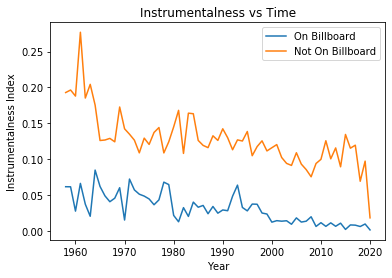

In [110]:
visualize_data_compare("instrumentalness")

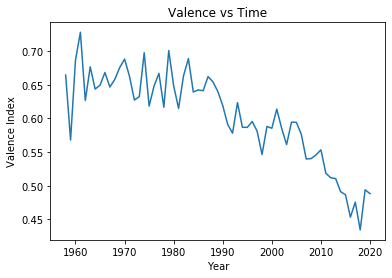

In [70]:
visualize_data("valence", bb_df)

In [ ]:
bb_df.plot(x ='year', y='loudness', kind = 'scatter')